In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import gc
import sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from ROPE import RotaryEmbedding
from ROAR import *

/home/jovyan/synthetic/ROPE.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/jovyan/synthetic/ROPE.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


## Calculate Model L2

In [3]:
def calculate_l2(model):
    l2 = None
    for param in model.parameters():
        if l2 is None:
            l2 = F.mse_loss(param, torch.zeros(param.shape, device=device), reduction="sum")
        else:
            l2 = l2 + F.mse_loss(param, torch.zeros(param.shape, device=device), reduction="sum")
    return l2

## Generate completions in a left-to-right order starting at a specific token index in the sequence

In [4]:
def generate_completions(model, test_batch, starting_chars=0, temperature=0.5, topk=5, topp=0.75, ls=None, reserved_tokens=2):
    print("Generating samples with temp of", temperature, "topk of", topk, "and topp of", topp)
    torch.manual_seed(0)
    model.eval()
    x_test_value = None
    x_test_value_orig = None
    #with torch.no_grad():
    x_test_seq = embed_sample(test_batch)
    x_test_type, x_test_value, seq_order = x_test_seq
    seq_order = (seq_order,)
    x_test_value = x_test_value.clone()
    x_test_value_orig = x_test_value.clone()
    for num_allowed_nodes in [0]:
        pbar = tqdm(range(starting_chars, x_test_value.shape[1]))
        for i in pbar:
            x_test_value[:,i:] = 0

            with torch.amp.autocast("cuda"):
                output = model.decoder(x_test_type, x_test_value, seq_order,)
                output = output.float().detach()
            
            gumbels = -torch.empty_like(output, device=device).exponential_().log()
            gumbel_probs = F.softmax(output + gumbels*temperature, dim=1)
            
            #top k
            p = (1/output.shape[1]) * topk
            quantiles = output.quantile(1-p, dim=1).reshape(output.shape[0],1,output.shape[2])
            gumbel_probs[output < quantiles] = 0
            
            #top p
            s = torch.softmax(output, dim=1)
            v, _ = s.sort(dim=1, descending=True)
            m = v.cumsum(dim=1) <= topp
            m[:,0,:] = True
            v = (m * v)
            v[v==0] = torch.inf
            mv, _ = v.min(dim=1)
            mv = mv.reshape(mv.shape[0], 1, mv.shape[1])
            gumbel_probs[s < mv] = 0
            
            x = gumbel_probs.argmax(dim=1)
            
            x_test_value[:,i:] = x[:,i:]
            
    orig_samples = np.array(x_test_value_orig.cpu()) - reserved_tokens
    test_batch = np.array(x_test_value.cpu()) - reserved_tokens

    orig_samples[orig_samples < 0] = 0
    test_batch[test_batch < 0] = 0
    
    orig = []
    samples = []
    value_diff = []
    for r in range(test_batch.shape[0]):
        orig_string = "".join([chr(item) for item in orig_samples[r]]).strip('\x00')
        orig.append(orig_string)
        string = "".join([chr(item) for item in test_batch[r]]).strip('\x00')
        try:
            if "==" in string:
                diff = eval(string.split("==")[0]) - eval(string.split("==")[-1])
            else:
                diff = np.nan
        except:
            diff = np.nan
        samples.append(string)
        value_diff.append(diff)
    print((np.array(value_diff) == 0).mean(), "ARE TRUE")
    print(np.nanmean(np.abs(np.array(value_diff))), "AVG DIFF")
 
    search_results["% True:"].append((np.array(value_diff) == 0).mean())
    search_results["Avg Diff"].append(np.nanmean(np.abs(np.array(value_diff))))
    search_results["Median Diff"].append(np.nanmedian(np.abs(np.array(value_diff))))

        
    df1 = pd.DataFrame({"completions":orig})
    df1.to_csv(f"./sample_output/text_samples_orig.csv")
    df2 = pd.DataFrame({"completions":samples, "value_diff": value_diff})
    df2.to_csv(f"./sample_output/text_samples.csv", escapechar='\\')

## Calculate the model loss when using a left-to-right sequence order

In [5]:
def test_model(model, test, test_batches, criterion, starting_chars=0, temperature=0.5, topk=5, topp=0.75, mode=""):
    torch.manual_seed(0)
    model.eval()
    #model.train()
    #with torch.no_grad():
    recording_indices = [0]
    losses = None
    pbar = tqdm(range(test_batches))
    test_iterator = iter(test)
    num_tests_done = 0
    for test_iter in pbar: 
        test_batch = next(test_iterator, None)
        if test_batch is not None:
            num_tests_done += 1
            loss_list = []
            x_test_tab = embed_sample(test_batch)

            #biased_scramble = not true random, simple_scramble = left_to_right, alternate_direction = randomly reverse order
            x_test_type_reordered, x_test_value_reordered, seq_order=scramble_order_seq(x_test_tab, biased_scramble=True, simple_scramble=True, alternate_direction=False)

            for i in range(model.n_bits+1):
                if i in recording_indices:
                    with torch.amp.autocast("cuda"):
                        _, output = model((x_test_type_reordered, x_test_value_reordered, seq_order), num_allowed_nodes = i)
                        loss = criterion(output, x_test_value_reordered) 
                        loss_list.append(float(loss))

            if losses is None:
                losses = np.array(loss_list)
            else:
                losses += np.array(loss_list)

    losses /= num_tests_done

    #save normal samples
    mean_test_loss = np.mean(losses[0:])
    min_test_loss = np.min(losses)
    min_error_node = int(torch.FloatTensor(losses).argmin())
    model.best_complexity = min_error_node
    
    print("L2 of", str(float(calculate_l2(model))))
    print("TEST ERROR OF "+str(round(min_test_loss,5)))

    generate_completions(model, test_batch, starting_chars=7, temperature=temperature, topk=topk, topp=topp, ls=criterion.label_smoothing)
    search_results["L2"].append(float(calculate_l2(model)))
    search_results["Test Error"].append(min_test_loss)
    pd.DataFrame(search_results).to_csv(f"sample_output/{mode}_record.csv")
    
    return min_test_loss

## Train model using specified strategy

In [27]:
def train_model(train, test, model, epochs=10, aux_loss_weight=0.01, checkpoint_filename="model.pyt",
                lr=1e-4, label_smoothing=0, weight_decay=0.01, test_batches=10, epochs_between_test=10, running_average_window=1000,
                temperature=0.5, topk=5, topp=0.75, mode="causal"):

    if mode == "causal":
        biased_scramble = True
        simple_scramble = True
        alternate_direction = False
    elif mode == "bidirectional":
        biased_scramble = True
        simple_scramble = True
        alternate_direction = True
    elif mode == "pseudorandom":
        biased_scramble = True
        simple_scramble = False
        alternate_direction = True
    elif mode == "random":
        biased_scramble = False
        simple_scramble = False
        alternate_direction = False
    else:
        print("use a valid mode")
        sys.exit()
        
    
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    
    model.train()
    iters = len(train)
    best_mean_test_loss = np.inf
    best_min_test_loss = np.inf
    epochs_since_best_loss = 0
    running_train_loss = []
    
    #training epochs
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = torch.amp.GradScaler("cuda")
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epochs+1, steps_per_epoch=iters, div_factor=1e4, pct_start=0.01)
    for epoch in range(epochs+1):
        #set seed here, seed is set again at test. 
        #If not reset after test this leads to overfitting since noise is the same each epoch
        torch.manual_seed(np.random.randint(99999999))
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        
        print("--------------------------------------\nEPOCH", epoch)
        pbar = tqdm(train)
        for iteration, batch in enumerate(pbar):
            
            x_train_tab = embed_sample(batch)

            #need to scramble order of tabular data and concat it
            x_train_type_reordered, x_train_value_reordered, seq_order = scramble_order_seq(x_train_tab, biased_scramble=biased_scramble, simple_scramble=simple_scramble, alternate_direction=alternate_direction)
            with torch.amp.autocast("cuda"):
                #add label noise
                #x_train_value_reordered = add_label_noise(x_train_value_reordered)
                
                enc, output = model((x_train_type_reordered, x_train_value_reordered, seq_order))
                
                loss = criterion(output, x_train_value_reordered)
                
                #aux loss
                if not model.binary_encodings and model.make_encodings:
                    loss = loss + (enc**2).mean()*aux_loss_weight 
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            scaler.step(optimizer)
            scaler.update()
            #scheduler.step()
            optimizer.zero_grad()
            
            
            running_train_loss.append(float(loss))
            running_train_loss = running_train_loss[-running_average_window:]

            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_description(f"Loss: {np.mean(running_train_loss):.4f} LR {current_lr:.8}")
        
        if epoch%epochs_between_test == 0:
            gc.collect()
            torch.cuda.empty_cache()
            #evaluate model
            min_test_loss = test_model(model, test, test_batches, criterion, temperature=temperature, topk=topk, topp=topp, mode=mode)
            if min_test_loss < best_min_test_loss:
                epochs_since_best_loss = 0
                best_min_test_loss = min_test_loss
                model.cpu()
                #torch.save(model.state_dict(), checkpoint_filename)
                model = model.to(device)
            print(f"{epochs_since_best_loss} EPOCHS SINCE BEST LOSS OF {best_min_test_loss}")
            epochs_since_best_loss += 1
                
        del output
        del loss
        
    model.eval()
    return model

## Embed each sample so it can be input into the random-order autoregressive model

In [7]:
#tokens reserved in advance
def embed_sample(batch):
    if debug:
        device = torch.device("cpu")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x, y, z = batch
    x = x.to(device)
    y = y.to(device)
    z = z.to(device)

    tab_type = x
    tab_value = y
    tab_pos1 = z

    tab_data = (tab_type.long(), tab_value.long(), tab_pos1.float())

    return tab_data

## Encode text into ints

In [8]:
def encode(line, desired_length):
    line = [ord(x) for x in line]
    base = torch.zeros((desired_length))
    seq = torch.LongTensor(line)
    base[0:seq.shape[0]] = seq
    return base.reshape(1,-1)

## Generate sum equalities very inefficiently, but it doesn't matter

In [9]:
def make_line(min_val, max_val, num_numbers):
    max_val +=1
    value = 0
    first_half = []
    for _ in range(num_numbers):
        num = np.random.randint(min_val+1,max_val)
        value += num
        num = "+"+str(num) if num >=0 else str(num)
        first_half.append(num)
    while True:
        second_half = []
        partial_sum = 0
        for _ in range(num_numbers-1):
            num = np.random.randint(min_val,max_val)
            partial_sum += num
            num = "+"+str(num) if num >=0 else str(num)
            second_half.append(num)
        
        if (value - partial_sum) <= max_val and (value - partial_sum) >= min_val:
            num = value - partial_sum
            num = "+"+str(num) if num >=0 else str(num)
            second_half.append(num)
            break

    return "".join(first_half).strip("+") + "==" + "".join(second_half).strip("+")

## Create sum equalities dataset

In [10]:
def make_datasets(min_val, max_val, num_numbers, max_len, reserved_tokens):
    synthetic_lines = []
    for i in range(1000000):
        synthetic_lines.append(make_line(min_val, max_val, num_numbers))

    X = [x[:max_len] for x in synthetic_lines]
    X = [x.encode("ascii", errors="ignore").decode() for x in X]
    X = torch.cat([encode(x, max_len) for x in X], axis=0).numpy()

    timestamps = []
    itemtypes = []
    values = []
    for t in tqdm(X):
        
        ts_tab, it_tab, va_tab = np.arange(max_len+2).reshape(1,max_len+2).astype(float), np.zeros((1,max_len+2), dtype=int), np.zeros((1,max_len+2), dtype=int)
        
        it_tab[0,1:len(t)+1] = reserved_tokens
        va_tab[0,1:len(t)+1] = t+reserved_tokens

        timestamps.append(ts_tab)
        itemtypes.append(it_tab)
        values.append(va_tab)
   
    data = (np.concatenate(itemtypes, dtype=int), np.concatenate(values, dtype=int), (np.concatenate(timestamps, dtype=float)))

    return data

## Setup training
Generate datasets consisting of sum equalities. Each sequence starts and ends with a padding token.

In [12]:
#tokens also reserved in the generate function
prepared_data = make_datasets(-99, 99, 2, max_len=14, reserved_tokens=2)

types, values, poistions = prepared_data
x_train_type, x_test_type, x_train_values, x_test_values, x_train_positions, x_test_positions = train_test_split(types, values, poistions, test_size=0.2, random_state=42)

  0%|          | 0/1000000 [00:00<?, ?it/s]

## Use 10,000 samples in the training dataset

In [13]:
n_train_samples = 10000

x_train_type = x_train_type[:n_train_samples]
x_train_values = x_train_values[:n_train_samples]
x_train_positions = x_train_positions[:n_train_samples]

## Use very large batches for stability at the high learning rate

In [14]:
train_batch_size=1024
test_batch_size=1024
num_workers=8

## Each "epoch" contains 1,000,000 samples randomly sampled from the training data. We test after each "epoch"

In [15]:
train = torch.utils.data.TensorDataset(torch.tensor(x_train_type), torch.tensor(x_train_values), torch.tensor(x_train_positions))
test = torch.utils.data.TensorDataset(torch.tensor(x_test_type), torch.tensor(x_test_values), torch.tensor(x_test_positions))

sampler = torch.utils.data.RandomSampler(train, replacement=True, num_samples=1000000)
trainldr = torch.utils.data.DataLoader(train, batch_size=train_batch_size, sampler=sampler, num_workers=num_workers, drop_last=True)
testldr = torch.utils.data.DataLoader(test, batch_size=test_batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [17]:
#################################################################################################
#Each "epoch" is 1,000,000 samples regardless of the true unique number of samples in the dataset
num_epochs = 300
#################################################################################################

## Train left-to-right model

In [18]:
#train causal
search_results = {"% True:":[], "Avg Diff":[], "Median Diff":[], "L2":[], "Test Error":[]}
model = DisorderTransformer(n_embedding=64, n_type_embedding=8, d_model=512, d_ff=1024, num_heads=8, depth=32, n_translation_layers=0, 
                            make_encodings=False, dropout_min_p=0, dropout_max_p=1).to(device)
model = torch.compile(model, fullgraph=True)
model = train_model(trainldr, testldr, model=model, epochs=num_epochs, test_batches=50,
                    checkpoint_filename="model.pyt", epochs_between_test=1, lr=1e-3,
                    label_smoothing=0, weight_decay=1, temperature=0,
                    mode="causal")

--------------------------------------
EPOCH 0


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 64658.72265625
TEST ERROR OF 1.1751
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.10546875 ARE TRUE
3.4099804305283756 AVG DIFF
0 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 1


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45275.9453125
TEST ERROR OF 1.64733
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.1220703125 ARE TRUE
4.818627450980392 AVG DIFF
1 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 2


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51440.25390625
TEST ERROR OF 2.08479
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.28515625 ARE TRUE
5.084148727984345 AVG DIFF
2 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 3


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 48690.2265625
TEST ERROR OF 2.17971
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.2783203125 ARE TRUE
5.93011811023622 AVG DIFF
3 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 4


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46972.16796875
TEST ERROR OF 2.23243
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.30859375 ARE TRUE
5.426470588235294 AVG DIFF
4 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 5


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46475.1171875
TEST ERROR OF 2.26353
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3310546875 ARE TRUE
5.4857703631010795 AVG DIFF
5 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 6


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46682.390625
TEST ERROR OF 2.26688
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3203125 ARE TRUE
6.1619234543670265 AVG DIFF
6 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 7


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 47229.15625
TEST ERROR OF 2.26734
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.33984375 ARE TRUE
6.416258570029383 AVG DIFF
7 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 8


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 47967.37109375
TEST ERROR OF 2.29535
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.314453125 ARE TRUE
6.528487229862476 AVG DIFF
8 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 9


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 48880.26953125
TEST ERROR OF 2.35861
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.35546875 ARE TRUE
5.763440860215054 AVG DIFF
9 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 10


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49975.2734375
TEST ERROR OF 2.34441
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.337890625 ARE TRUE
6.206457925636008 AVG DIFF
10 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 11


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51247.015625
TEST ERROR OF 2.34199
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3623046875 ARE TRUE
6.445205479452055 AVG DIFF
11 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 12


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 52671.83984375
TEST ERROR OF 2.36171
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3544921875 ARE TRUE
6.682306940371457 AVG DIFF
12 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 13


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53863.890625
TEST ERROR OF 2.4259
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.380859375 ARE TRUE
7.00293542074364 AVG DIFF
13 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 14


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 54551.984375
TEST ERROR OF 2.42373
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.37109375 ARE TRUE
6.87524557956778 AVG DIFF
14 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 15


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55263.6875
TEST ERROR OF 2.4516
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.359375 ARE TRUE
6.5458984375 AVG DIFF
15 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 16


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55831.98046875
TEST ERROR OF 2.43185
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.353515625 ARE TRUE
6.78256611165524 AVG DIFF
16 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 17


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55792.5234375
TEST ERROR OF 2.44697
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.359375 ARE TRUE
7.919843597262952 AVG DIFF
17 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 18


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55663.5078125
TEST ERROR OF 2.49445
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3701171875 ARE TRUE
6.999019607843137 AVG DIFF
18 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 19


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55934.01953125
TEST ERROR OF 2.52407
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3603515625 ARE TRUE
6.500488758553275 AVG DIFF
19 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 20


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 56088.95703125
TEST ERROR OF 2.52959
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3427734375 ARE TRUE
7.542074363992172 AVG DIFF
20 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 21


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55693.4921875
TEST ERROR OF 2.56128
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3525390625 ARE TRUE
6.537634408602151 AVG DIFF
21 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 22


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55821.43359375
TEST ERROR OF 2.53548
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.36328125 ARE TRUE
6.8824681684622915 AVG DIFF
22 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 23


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55770.76953125
TEST ERROR OF 2.52652
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.349609375 ARE TRUE
6.599804305283757 AVG DIFF
23 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 24


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55643.05859375
TEST ERROR OF 2.60152
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.326171875 ARE TRUE
8.12426614481409 AVG DIFF
24 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 25


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55637.62890625
TEST ERROR OF 2.48962
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3671875 ARE TRUE
8.799803729146221 AVG DIFF
26 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 27


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55853.33203125
TEST ERROR OF 2.5349
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.369140625 ARE TRUE
8.084396467124632 AVG DIFF
29 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 30


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55408.15625
TEST ERROR OF 2.57315
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.36328125 ARE TRUE
7.089128305582762 AVG DIFF
30 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 31


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55849.375
TEST ERROR OF 2.61471
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3623046875 ARE TRUE
7.517173699705594 AVG DIFF
31 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 32


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55300.10546875
TEST ERROR OF 2.55749
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3525390625 ARE TRUE
7.506849315068493 AVG DIFF
32 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 33


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 55115.05078125
TEST ERROR OF 2.66897
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3603515625 ARE TRUE
8.590373280943025 AVG DIFF
33 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 34


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 54483.5859375
TEST ERROR OF 2.55198
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.369140625 ARE TRUE
6.95405669599218 AVG DIFF
34 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 35


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 54034.33203125
TEST ERROR OF 2.6406
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3701171875 ARE TRUE
7.437806072477962 AVG DIFF
35 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 36


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53965.5390625
TEST ERROR OF 2.60903
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.37890625 ARE TRUE
7.466731898238748 AVG DIFF
36 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 37


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 54038.95703125
TEST ERROR OF 2.5655
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.353515625 ARE TRUE
7.702252693437806 AVG DIFF
37 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 38


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53877.81640625
TEST ERROR OF 2.53956
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3515625 ARE TRUE
7.570450097847358 AVG DIFF
38 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 39


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 54127.73046875
TEST ERROR OF 2.39827
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.375 ARE TRUE
8.625490196078431 AVG DIFF
39 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 40


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53575.0
TEST ERROR OF 2.6474
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3662109375 ARE TRUE
7.0724070450097845 AVG DIFF
40 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 41


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53683.15625
TEST ERROR OF 2.67407
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.376953125 ARE TRUE
7.792156862745098 AVG DIFF
41 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 42


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53897.80078125
TEST ERROR OF 2.56487
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3916015625 ARE TRUE
11.74705882352941 AVG DIFF
42 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 43


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53661.10546875
TEST ERROR OF 2.62253
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.361328125 ARE TRUE
7.6330724070450096 AVG DIFF
43 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 44


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53532.09375
TEST ERROR OF 2.60102
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.36328125 ARE TRUE
6.938295788442703 AVG DIFF
44 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 45


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53651.0390625
TEST ERROR OF 2.65984
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3671875 ARE TRUE
8.437927663734115 AVG DIFF
45 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 46


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53765.953125
TEST ERROR OF 2.60105
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3544921875 ARE TRUE
8.5830078125 AVG DIFF
46 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 47


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53866.4140625
TEST ERROR OF 2.60857
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3662109375 ARE TRUE
7.88050930460333 AVG DIFF
47 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 48


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53708.54296875
TEST ERROR OF 2.63113
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.357421875 ARE TRUE
7.490234375 AVG DIFF
48 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 49


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53696.25
TEST ERROR OF 2.65728
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.341796875 ARE TRUE
7.488258317025441 AVG DIFF
49 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 50


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53357.234375
TEST ERROR OF 2.63943
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3525390625 ARE TRUE
7.194906953966699 AVG DIFF
50 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 51


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53244.26171875
TEST ERROR OF 2.70014
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.36328125 ARE TRUE
7.94140625 AVG DIFF
51 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 52


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53207.2734375
TEST ERROR OF 2.63074
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.365234375 ARE TRUE
7.906158357771261 AVG DIFF
52 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 53


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53028.078125
TEST ERROR OF 2.61356
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.36328125 ARE TRUE
7.359882005899705 AVG DIFF
53 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 54


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 53308.23828125
TEST ERROR OF 2.60725
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3583984375 ARE TRUE
7.613188976377953 AVG DIFF
54 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 55


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 52582.3203125
TEST ERROR OF 2.67539
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.33984375 ARE TRUE
8.68235294117647 AVG DIFF
55 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 56


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 52449.12109375
TEST ERROR OF 2.61918
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3828125 ARE TRUE
7.069471624266145 AVG DIFF
56 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 57


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51905.3828125
TEST ERROR OF 2.6291
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3505859375 ARE TRUE
7.955034213098729 AVG DIFF
57 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 58


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 52036.171875
TEST ERROR OF 2.54254
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3857421875 ARE TRUE
6.8916015625 AVG DIFF
58 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 59


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51791.3046875
TEST ERROR OF 2.65275
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.388671875 ARE TRUE
7.973607038123167 AVG DIFF
59 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 60


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51941.35546875
TEST ERROR OF 2.566
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.390625 ARE TRUE
7.5019607843137255 AVG DIFF
60 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 61


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51778.91015625
TEST ERROR OF 2.62846
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.37890625 ARE TRUE
7.2900390625 AVG DIFF
61 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 62


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51968.71875
TEST ERROR OF 2.61763
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.388671875 ARE TRUE
8.493150684931507 AVG DIFF
62 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 63


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51852.9140625
TEST ERROR OF 2.58333
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.375 ARE TRUE
7.566797642436149 AVG DIFF
63 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 64


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51869.6171875
TEST ERROR OF 2.61829
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3779296875 ARE TRUE
8.69208211143695 AVG DIFF
64 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 65


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51866.46484375
TEST ERROR OF 2.54701
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3798828125 ARE TRUE
7.62133072407045 AVG DIFF
65 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 66


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 52114.94140625
TEST ERROR OF 2.67024
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3662109375 ARE TRUE
7.621939275220372 AVG DIFF
66 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 67


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 52112.6171875
TEST ERROR OF 2.58575
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.390625 ARE TRUE
8.933398628795299 AVG DIFF
67 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 68


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 52208.00390625
TEST ERROR OF 2.57938
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3818359375 ARE TRUE
7.989236790606654 AVG DIFF
68 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 69


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51819.1953125
TEST ERROR OF 2.64147
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.369140625 ARE TRUE
9.022504892367905 AVG DIFF
69 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 70


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51969.9296875
TEST ERROR OF 2.59403
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3759765625 ARE TRUE
17.518084066471165 AVG DIFF
70 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 71


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51794.5625
TEST ERROR OF 2.62842
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.37890625 ARE TRUE
7.312805474095796 AVG DIFF
71 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 72


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51654.15234375
TEST ERROR OF 2.6867
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3837890625 ARE TRUE
7.453294001966569 AVG DIFF
72 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 73


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51668.11328125
TEST ERROR OF 2.59132
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.40625 ARE TRUE
7.162109375 AVG DIFF
73 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 74


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51922.390625
TEST ERROR OF 2.56863
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3837890625 ARE TRUE
8.901077375122428 AVG DIFF
74 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 75


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51545.01953125
TEST ERROR OF 2.63706
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.380859375 ARE TRUE
8.332679097154072 AVG DIFF
75 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 76


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51640.07421875
TEST ERROR OF 2.71967
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3916015625 ARE TRUE
8.510263929618768 AVG DIFF
76 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 77


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51633.40234375
TEST ERROR OF 2.55484
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.37890625 ARE TRUE
7.901174168297456 AVG DIFF
77 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 78


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51744.53125
TEST ERROR OF 2.56251
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.392578125 ARE TRUE
7.829912023460411 AVG DIFF
78 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 79


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51757.5390625
TEST ERROR OF 2.57684
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.3837890625 ARE TRUE
7.181372549019608 AVG DIFF
79 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 80


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51662.01953125
TEST ERROR OF 2.6419
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.4169921875 ARE TRUE
7.5234375 AVG DIFF
80 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 81


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 51798.69140625
TEST ERROR OF 2.63896
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.4072265625 ARE TRUE
8.455882352941176 AVG DIFF
81 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 82


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 52098.69921875
TEST ERROR OF 2.61074
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.423828125 ARE TRUE
8.261040235525025 AVG DIFF
82 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 83


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 50637.42578125
TEST ERROR OF 2.45562
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.4697265625 ARE TRUE
8.346379647749512 AVG DIFF
83 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 84


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 50585.09765625
TEST ERROR OF 2.47314
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.4697265625 ARE TRUE
9.685966633954857 AVG DIFF
84 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 85


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 50685.8515625
TEST ERROR OF 2.40594
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.4990234375 ARE TRUE
7.304007820136852 AVG DIFF
85 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 86


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 50637.1640625
TEST ERROR OF 2.37543
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.501953125 ARE TRUE
16.41153470185728 AVG DIFF
86 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 87


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49842.375
TEST ERROR OF 2.37412
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5234375 ARE TRUE
9.180039138943249 AVG DIFF
87 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 88


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 50296.140625
TEST ERROR OF 2.38243
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.525390625 ARE TRUE
7.6611328125 AVG DIFF
88 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 89


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49528.16015625
TEST ERROR OF 2.33701
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5400390625 ARE TRUE
16.271037181996086 AVG DIFF
89 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 90


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49543.5390625
TEST ERROR OF 2.35286
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5185546875 ARE TRUE
8.52297165200391 AVG DIFF
90 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 91


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49606.95703125
TEST ERROR OF 2.37445
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.53125 ARE TRUE
8.856304985337243 AVG DIFF
91 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 92


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49505.609375
TEST ERROR OF 2.40163
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5166015625 ARE TRUE
11.142576204523108 AVG DIFF
92 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 93


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49321.625
TEST ERROR OF 2.36137
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.541015625 ARE TRUE
7.669607843137255 AVG DIFF
93 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 94


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49458.5546875
TEST ERROR OF 2.4149
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.529296875 ARE TRUE
8.26027397260274 AVG DIFF
94 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 95


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49437.87890625
TEST ERROR OF 2.40637
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5078125 ARE TRUE
10.4072265625 AVG DIFF
95 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 96


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49969.6953125
TEST ERROR OF 2.32854
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5263671875 ARE TRUE
8.63600782778865 AVG DIFF
96 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 97


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49748.109375
TEST ERROR OF 2.3723
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.4931640625 ARE TRUE
9.3837890625 AVG DIFF
97 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 98


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 50388.734375
TEST ERROR OF 2.43922
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.515625 ARE TRUE
26.50439882697947 AVG DIFF
98 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 99


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49320.84375
TEST ERROR OF 2.34846
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5205078125 ARE TRUE
8.73972602739726 AVG DIFF
99 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 100


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49850.6875
TEST ERROR OF 2.34311
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.525390625 ARE TRUE
7.550342130987293 AVG DIFF
100 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 101


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49342.9921875
TEST ERROR OF 2.35684
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5126953125 ARE TRUE
8.313667649950835 AVG DIFF
101 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 102


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49464.984375
TEST ERROR OF 2.42107
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.541015625 ARE TRUE
9.21484375 AVG DIFF
102 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 103


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49120.19921875
TEST ERROR OF 2.37943
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5166015625 ARE TRUE
7.356793743890518 AVG DIFF
103 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 104


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49224.25
TEST ERROR OF 2.31472
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.529296875 ARE TRUE
8.706457925636007 AVG DIFF
104 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 105


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49446.765625
TEST ERROR OF 2.33054
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5361328125 ARE TRUE
8.982387475538161 AVG DIFF
105 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 106


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49725.6484375
TEST ERROR OF 2.45573
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.525390625 ARE TRUE
8.548387096774194 AVG DIFF
106 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 107


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49692.9296875
TEST ERROR OF 2.45321
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.541015625 ARE TRUE
7.737978410206084 AVG DIFF
107 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 108


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 50184.62890625
TEST ERROR OF 2.37876
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5576171875 ARE TRUE
8.732876712328768 AVG DIFF
108 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 109


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 50019.9375
TEST ERROR OF 2.36582
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5166015625 ARE TRUE
9.2119140625 AVG DIFF
109 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 110


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49485.61328125
TEST ERROR OF 2.33739
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.53125 ARE TRUE
7.824853228962818 AVG DIFF
110 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 111


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49694.4296875
TEST ERROR OF 2.22674
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.513671875 ARE TRUE
9.6728515625 AVG DIFF
111 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 112


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49518.66015625
TEST ERROR OF 2.37241
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.521484375 ARE TRUE
8.486328125 AVG DIFF
112 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 113


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49310.140625
TEST ERROR OF 2.3451
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5478515625 ARE TRUE
7.204301075268817 AVG DIFF
113 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 114


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49395.421875
TEST ERROR OF 2.42475
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5 ARE TRUE
8.17106549364614 AVG DIFF
114 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 115


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49552.24609375
TEST ERROR OF 2.38303
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5126953125 ARE TRUE
8.592156862745098 AVG DIFF
115 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 116


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49480.2734375
TEST ERROR OF 2.32758
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5283203125 ARE TRUE
7.749510763209393 AVG DIFF
116 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 117


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49892.03515625
TEST ERROR OF 2.31513
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.537109375 ARE TRUE
10.356793743890519 AVG DIFF
117 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 118


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 49118.91015625
TEST ERROR OF 2.24822
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5400390625 ARE TRUE
7.259765625 AVG DIFF
118 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 119


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 48549.22265625
TEST ERROR OF 2.3671
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.544921875 ARE TRUE
7.3583984375 AVG DIFF
119 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 120


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 48903.56640625
TEST ERROR OF 2.29022
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5283203125 ARE TRUE
8.080156402737048 AVG DIFF
120 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 121


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 48394.56640625
TEST ERROR OF 2.39348
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.517578125 ARE TRUE
10.662756598240469 AVG DIFF
122 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 123


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 47441.8046875
TEST ERROR OF 2.18537
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5322265625 ARE TRUE
8.545009784735813 AVG DIFF
137 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 138


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 47209.91796875
TEST ERROR OF 2.34341
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.517578125 ARE TRUE
7.650390625 AVG DIFF
138 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 139


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 47526.12109375
TEST ERROR OF 2.3008
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5380859375 ARE TRUE
8.160626836434869 AVG DIFF
139 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 140


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 47960.9296875
TEST ERROR OF 2.31927
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5283203125 ARE TRUE
10.188845401174168 AVG DIFF
140 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 141


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 47792.53125
TEST ERROR OF 2.34751
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5439453125 ARE TRUE
8.619373776908024 AVG DIFF
141 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 142


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 47031.5625
TEST ERROR OF 2.38568
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5029296875 ARE TRUE
7.690127077223852 AVG DIFF
142 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 143


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46769.80078125
TEST ERROR OF 2.34464
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.51171875 ARE TRUE
8.6015625 AVG DIFF
143 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 144


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46921.234375
TEST ERROR OF 2.38875
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.521484375 ARE TRUE
9.42270058708415 AVG DIFF
144 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 145


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46792.73046875
TEST ERROR OF 2.3776
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.541015625 ARE TRUE
7.204121687929343 AVG DIFF
145 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 146


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46867.953125
TEST ERROR OF 2.38574
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5478515625 ARE TRUE
9.289911851126346 AVG DIFF
146 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 147


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46930.92578125
TEST ERROR OF 2.37348
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5400390625 ARE TRUE
7.526418786692759 AVG DIFF
147 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 148


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46313.4296875
TEST ERROR OF 2.28947
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5400390625 ARE TRUE
7.49412915851272 AVG DIFF
148 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 149


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46506.92578125
TEST ERROR OF 2.29921
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.53125 ARE TRUE
8.7666015625 AVG DIFF
149 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 150


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46217.75
TEST ERROR OF 2.38475
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5029296875 ARE TRUE
14.76953125 AVG DIFF
150 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 151


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46072.01953125
TEST ERROR OF 2.41264
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.51953125 ARE TRUE
11.593352883675465 AVG DIFF
151 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 152


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45860.8828125
TEST ERROR OF 2.34989
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5322265625 ARE TRUE
8.01661779081134 AVG DIFF
152 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 153


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45708.61328125
TEST ERROR OF 2.3756
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.53125 ARE TRUE
7.743639921722114 AVG DIFF
153 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 154


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45933.1796875
TEST ERROR OF 2.32702
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5390625 ARE TRUE
8.61839530332681 AVG DIFF
154 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 155


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45565.44921875
TEST ERROR OF 2.39563
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5302734375 ARE TRUE
8.0 AVG DIFF
155 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 156


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45893.09375
TEST ERROR OF 2.35729
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5478515625 ARE TRUE
8.283479960899315 AVG DIFF
156 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 157


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45916.53515625
TEST ERROR OF 2.33628
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.517578125 ARE TRUE
8.1337890625 AVG DIFF
157 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 158


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45826.9609375
TEST ERROR OF 2.3404
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.544921875 ARE TRUE
7.916911045943304 AVG DIFF
158 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 159


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45461.46484375
TEST ERROR OF 2.34025
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.521484375 ARE TRUE
8.935420743639922 AVG DIFF
159 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 160


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44991.22265625
TEST ERROR OF 2.29205
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.52734375 ARE TRUE
9.27859237536657 AVG DIFF
160 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 161


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45934.23828125
TEST ERROR OF 2.42627
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.525390625 ARE TRUE
7.4150390625 AVG DIFF
161 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 162


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44652.52734375
TEST ERROR OF 2.39901
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.51953125 ARE TRUE
8.5673828125 AVG DIFF
162 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 163


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44881.5703125
TEST ERROR OF 2.32512
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5087890625 ARE TRUE
7.328445747800586 AVG DIFF
163 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 164


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45756.1875
TEST ERROR OF 2.39453
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.537109375 ARE TRUE
9.0703125 AVG DIFF
164 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 165


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44337.4140625
TEST ERROR OF 2.3542
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5498046875 ARE TRUE
8.664711632453567 AVG DIFF
165 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 166


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44863.046875
TEST ERROR OF 2.40863
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.52734375 ARE TRUE
8.3069403714565 AVG DIFF
166 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 167


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45102.34765625
TEST ERROR OF 2.32373
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5390625 ARE TRUE
8.291585127201566 AVG DIFF
167 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 168


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45474.78515625
TEST ERROR OF 2.37945
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5009765625 ARE TRUE
8.265884652981427 AVG DIFF
168 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 169


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45192.15625
TEST ERROR OF 2.34927
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5322265625 ARE TRUE
7.04296875 AVG DIFF
169 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 170


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45642.39453125
TEST ERROR OF 2.26565
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.52734375 ARE TRUE
7.90625 AVG DIFF
170 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 171


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45682.99609375
TEST ERROR OF 2.37346
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5498046875 ARE TRUE
7.06464250734574 AVG DIFF
171 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 172


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45422.89453125
TEST ERROR OF 2.26521
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5419921875 ARE TRUE
7.730205278592376 AVG DIFF
172 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 173


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45455.79296875
TEST ERROR OF 2.33153
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.52734375 ARE TRUE
9.8779296875 AVG DIFF
173 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 174


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45700.94140625
TEST ERROR OF 2.32025
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5322265625 ARE TRUE
8.814090019569472 AVG DIFF
174 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 175


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45803.51171875
TEST ERROR OF 2.36848
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.544921875 ARE TRUE
7.90625 AVG DIFF
175 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 176


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45653.20703125
TEST ERROR OF 2.40581
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5458984375 ARE TRUE
6.645445641527914 AVG DIFF
176 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 177


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45579.09765625
TEST ERROR OF 2.36159
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.537109375 ARE TRUE
7.379647749510763 AVG DIFF
177 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 178


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45189.0390625
TEST ERROR OF 2.35978
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5341796875 ARE TRUE
8.136986301369863 AVG DIFF
178 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 179


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45305.4375
TEST ERROR OF 2.3501
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.54296875 ARE TRUE
8.654260528893241 AVG DIFF
179 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 180


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45767.05078125
TEST ERROR OF 2.36193
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5390625 ARE TRUE
8.728250244379277 AVG DIFF
181 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 182


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44814.98046875
TEST ERROR OF 2.31158
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.53125 ARE TRUE
8.9482421875 AVG DIFF
230 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 231


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44566.375
TEST ERROR OF 2.40334
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.525390625 ARE TRUE
7.6950146627565985 AVG DIFF
263 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 264


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44767.87890625
TEST ERROR OF 2.39441
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5322265625 ARE TRUE
8.286412512218964 AVG DIFF
264 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 265


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44592.54296875
TEST ERROR OF 2.24947
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5400390625 ARE TRUE
7.0791788856304985 AVG DIFF
265 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 266


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44567.2109375
TEST ERROR OF 2.42827
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5517578125 ARE TRUE
6.2724609375 AVG DIFF
266 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 267


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44890.60546875
TEST ERROR OF 2.31873
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5224609375 ARE TRUE
7.297747306562194 AVG DIFF
267 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 268


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44692.1171875
TEST ERROR OF 2.35009
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.544921875 ARE TRUE
7.550342130987293 AVG DIFF
268 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 269


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44549.390625
TEST ERROR OF 2.28885
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5576171875 ARE TRUE
6.166503428011753 AVG DIFF
269 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 270


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44649.21484375
TEST ERROR OF 2.34792
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.55078125 ARE TRUE
7.457843137254902 AVG DIFF
270 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 271


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44826.40234375
TEST ERROR OF 2.30595
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5146484375 ARE TRUE
8.539138943248533 AVG DIFF
271 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 272


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44363.4609375
TEST ERROR OF 2.42532
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5205078125 ARE TRUE
8.7133072407045 AVG DIFF
272 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 273


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44450.91796875
TEST ERROR OF 2.39618
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.525390625 ARE TRUE
7.560117302052786 AVG DIFF
273 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 274


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44064.18359375
TEST ERROR OF 2.40466
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.529296875 ARE TRUE
8.694716242661448 AVG DIFF
274 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 275


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44127.859375
TEST ERROR OF 2.31109
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5517578125 ARE TRUE
7.4186274509803924 AVG DIFF
275 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 276


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44113.515625
TEST ERROR OF 2.38949
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5234375 ARE TRUE
7.795499021526418 AVG DIFF
276 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 277


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44464.5078125
TEST ERROR OF 2.40359
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.541015625 ARE TRUE
7.8993157380254155 AVG DIFF
277 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 278


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44585.359375
TEST ERROR OF 2.39265
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.52734375 ARE TRUE
8.909803921568628 AVG DIFF
278 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 279


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44634.828125
TEST ERROR OF 2.35595
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5458984375 ARE TRUE
8.262745098039217 AVG DIFF
279 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 280


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44966.62890625
TEST ERROR OF 2.4099
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.533203125 ARE TRUE
6.588062622309198 AVG DIFF
280 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 281


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44427.24609375
TEST ERROR OF 2.34823
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5517578125 ARE TRUE
6.808406647116325 AVG DIFF
281 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 282


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44358.80859375
TEST ERROR OF 2.29199
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5634765625 ARE TRUE
7.3124387855044075 AVG DIFF
282 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 283


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 43954.87109375
TEST ERROR OF 2.38214
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.5537109375 ARE TRUE
7.247796278158668 AVG DIFF
283 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 284


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44088.40234375
TEST ERROR OF 2.41814
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.533203125 ARE TRUE
7.570869990224829 AVG DIFF
284 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 285


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 43937.09765625
TEST ERROR OF 2.41378
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.541015625 ARE TRUE
8.175490196078432 AVG DIFF
285 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 286


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44147.48828125
TEST ERROR OF 2.33807
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.517578125 ARE TRUE
7.756360078277886 AVG DIFF
286 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 287


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44378.41796875
TEST ERROR OF 2.38423
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.525390625 ARE TRUE
8.052785923753666 AVG DIFF
287 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 288


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44199.77734375
TEST ERROR OF 2.43171
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.513671875 ARE TRUE
8.75294117647059 AVG DIFF
289 EPOCHS SINCE BEST LOSS OF 1.1750994539260864
--------------------------------------
EPOCH 290


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Train model which alternates left-to-right and right-to-left

In [19]:
#train bidirectional
search_results = {"% True:":[], "Avg Diff":[], "Median Diff":[], "L2":[], "Test Error":[]}
model = DisorderTransformer(n_embedding=64, n_type_embedding=8, d_model=512, d_ff=1024, num_heads=8, depth=32, n_translation_layers=0, 
                            make_encodings=False, dropout_min_p=0, dropout_max_p=1).to(device)
model = torch.compile(model, fullgraph=True)
model = train_model(trainldr, testldr, model=model, epochs=num_epochs, test_batches=50,
                    checkpoint_filename="model.pyt", epochs_between_test=1, lr=1e-3,
                    label_smoothing=0, weight_decay=1, temperature=0,
                    mode="bidirectional")

--------------------------------------
EPOCH 0


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 48740.890625
TEST ERROR OF 1.66562
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.8291015625 ARE TRUE
2.300097751710655 AVG DIFF
43 EPOCHS SINCE BEST LOSS OF 1.1475877475738525
--------------------------------------
EPOCH 47


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 48436.83203125
TEST ERROR OF 1.70367
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.83984375 ARE TRUE
3.505859375 AVG DIFF
44 EPOCHS SINCE BEST LOSS OF 1.1475877475738525
--------------------------------------
EPOCH 48


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46324.55078125
TEST ERROR OF 1.77315
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.8798828125 ARE TRUE
3.55859375 AVG DIFF
92 EPOCHS SINCE BEST LOSS OF 1.1475877475738525
--------------------------------------
EPOCH 96


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46611.7890625
TEST ERROR OF 1.7502
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.90625 ARE TRUE
3.497551420176298 AVG DIFF
141 EPOCHS SINCE BEST LOSS OF 1.1475877475738525
--------------------------------------
EPOCH 145


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46166.90625
TEST ERROR OF 1.79242
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.9111328125 ARE TRUE
12.448579823702254 AVG DIFF
189 EPOCHS SINCE BEST LOSS OF 1.1475877475738525
--------------------------------------
EPOCH 193


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46356.44921875
TEST ERROR OF 1.80642
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.921875 ARE TRUE
2.3515625 AVG DIFF
190 EPOCHS SINCE BEST LOSS OF 1.1475877475738525
--------------------------------------
EPOCH 194


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45946.9609375
TEST ERROR OF 1.79795
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.9375 ARE TRUE
5.623655913978495 AVG DIFF
239 EPOCHS SINCE BEST LOSS OF 1.1475877475738525
--------------------------------------
EPOCH 243


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46018.66796875
TEST ERROR OF 1.81751
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.943359375 ARE TRUE
2.533203125 AVG DIFF
288 EPOCHS SINCE BEST LOSS OF 1.1475877475738525
--------------------------------------
EPOCH 292


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Train model which uses a pseudo-random sequence order. 

Sequence order is random but the "next" token in the sequence is biased to be "near" the "previous" token in the original sequence. This simplifies the learning objective dramatically while retaining the desired randomness.

In [20]:
#train pseudo-random
search_results = {"% True:":[], "Avg Diff":[], "Median Diff":[], "L2":[], "Test Error":[]}
model = DisorderTransformer(n_embedding=64, n_type_embedding=8, d_model=512, d_ff=1024, num_heads=8, depth=32, n_translation_layers=0, 
                            make_encodings=False, dropout_min_p=0, dropout_max_p=1).to(device)
model = torch.compile(model, fullgraph=True)
model = train_model(trainldr, testldr, model=model, epochs=num_epochs, test_batches=50,
                    checkpoint_filename="model.pyt", epochs_between_test=1, lr=1e-3,
                    label_smoothing=0, weight_decay=1, temperature=0,
                    mode="pseudorandom")

--------------------------------------
EPOCH 0


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44538.10546875
TEST ERROR OF 1.17352
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.31640625 ARE TRUE
1.53515625 AVG DIFF
0 EPOCHS SINCE BEST LOSS OF 1.1735246133804322
--------------------------------------
EPOCH 48


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45783.4765625
TEST ERROR OF 1.13876
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.548828125 ARE TRUE
1.2607421875 AVG DIFF
0 EPOCHS SINCE BEST LOSS OF 1.1387622141838074
--------------------------------------
EPOCH 49


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45041.8828125
TEST ERROR OF 1.15766
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.943359375 ARE TRUE
0.642578125 AVG DIFF
38 EPOCHS SINCE BEST LOSS OF 1.0676458334922792
--------------------------------------
EPOCH 97


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46455.16796875
TEST ERROR OF 1.20428
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.9404296875 ARE TRUE
1.369140625 AVG DIFF
86 EPOCHS SINCE BEST LOSS OF 1.0676458334922792
--------------------------------------
EPOCH 145


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 46159.0859375
TEST ERROR OF 1.22386
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.9453125 ARE TRUE
1.1865234375 AVG DIFF
87 EPOCHS SINCE BEST LOSS OF 1.0676458334922792
--------------------------------------
EPOCH 146


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45917.55859375
TEST ERROR OF 1.22769
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.9482421875 ARE TRUE
0.755859375 AVG DIFF
134 EPOCHS SINCE BEST LOSS OF 1.0676458334922792
--------------------------------------
EPOCH 193


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44926.22265625
TEST ERROR OF 1.25565
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.9560546875 ARE TRUE
1.0851272015655578 AVG DIFF
182 EPOCHS SINCE BEST LOSS OF 1.0676458334922792
--------------------------------------
EPOCH 241


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 45181.74609375
TEST ERROR OF 1.22862
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.9462890625 ARE TRUE
0.8349609375 AVG DIFF
230 EPOCHS SINCE BEST LOSS OF 1.0676458334922792
--------------------------------------
EPOCH 289


  0%|          | 0/976 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44392.13671875
TEST ERROR OF 1.22845
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.94140625 ARE TRUE
1.0546875 AVG DIFF
239 EPOCHS SINCE BEST LOSS OF 1.0676458334922792
--------------------------------------
EPOCH 298


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44744.046875
TEST ERROR OF 1.23454
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.9384765625 ARE TRUE
1.3238747553816046 AVG DIFF
240 EPOCHS SINCE BEST LOSS OF 1.0676458334922792
--------------------------------------
EPOCH 299


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44687.44921875
TEST ERROR OF 1.24371
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.953125 ARE TRUE
0.5654296875 AVG DIFF
241 EPOCHS SINCE BEST LOSS OF 1.0676458334922792
--------------------------------------
EPOCH 300


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L2 of 44767.96484375
TEST ERROR OF 1.24064
Generating samples with temp of 0 topk of 5 and topp of 0.75


  0%|          | 0/9 [00:00<?, ?it/s]

0.9111328125 ARE TRUE
2.1669921875 AVG DIFF
242 EPOCHS SINCE BEST LOSS OF 1.0676458334922792


## Plot training runs

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
series_causal = pd.read_csv("sample_output/causal_record.csv", index_col=0)[:300]
series_bi = pd.read_csv("sample_output/bidirectional_record.csv", index_col=0)[:300]
series_biased = pd.read_csv("sample_output/pseudorandom_record.csv", index_col=0)[:300]

In [42]:
def plot_values(causal_df, bi_df, biased_df, column):
    df1 = causal_df[[column]].copy()
    df1["Experiment"] = "Left-to-Right"

    df2 = bi_df[[column]].copy()
    df2["Experiment"] = "Alternating Direction"

    df3 = biased_df[[column]].copy()
    df3["Experiment"] = "Pseudo-Random"


    df = pd.concat([df1, df2, df3])
    df["Experiment"] = df["Experiment"].astype(str)
    df = df.reset_index()
    df["index"] = df["index"] * 100
    sns.lineplot(data=df, y=column, x="index", hue="Experiment")
    plt.grid(True)

## Proportion of sequences completed in a valid way

i.e. left sum == right sum

Text(0.5, 0, 'Training Epochs')

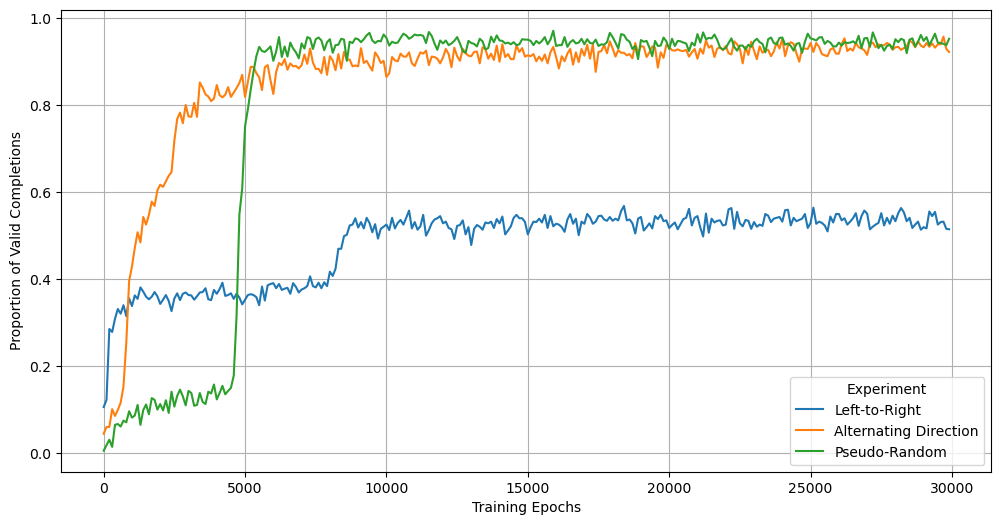

In [43]:
plt.figure(figsize=(12, 6))
plot_values(series_causal, series_bi, series_biased, "% True:")
plt.ylabel("Proportion of Valid Completions")
plt.xlabel("Training Epochs")

## L2 of each model during training

Text(0.5, 0, 'Epochs')

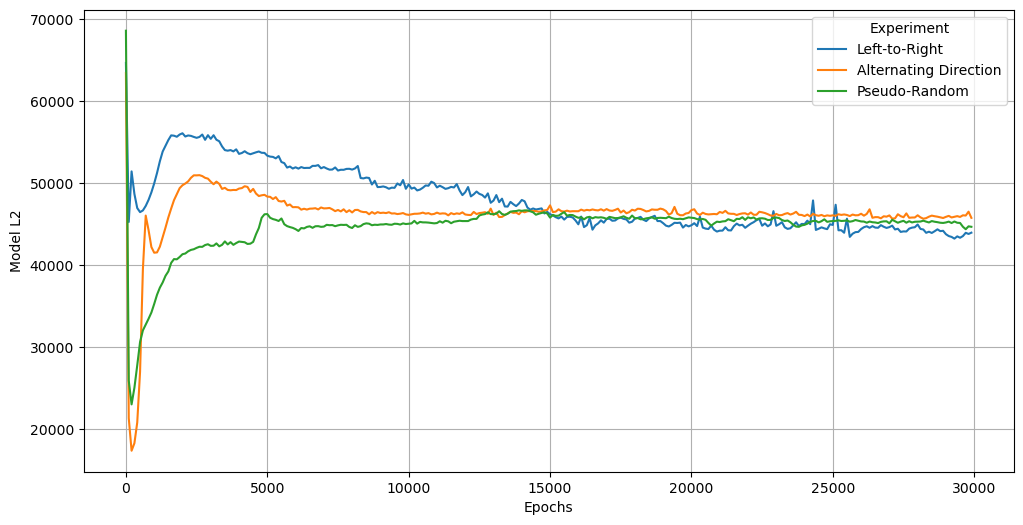

In [45]:
plt.figure(figsize=(12, 6))
plot_values(series_causal, series_bi, series_biased, "L2")
plt.ylabel("Model L2")
plt.xlabel("Epochs")

## Left-to-right testing loss during training

Text(0.5, 0, 'Epochs')

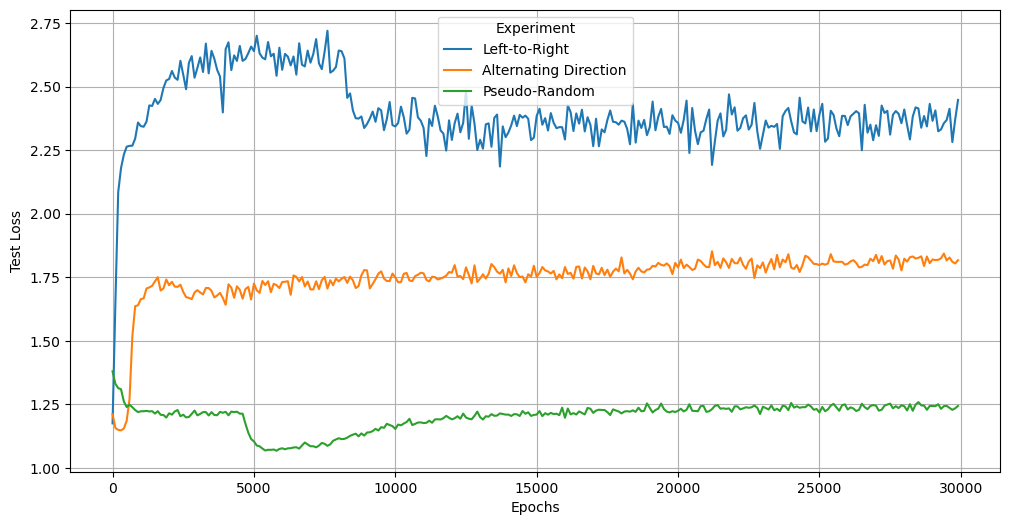

In [46]:
plt.figure(figsize=(12, 6))
plot_values(series_causal, series_bi, series_biased, "Test Error")
plt.ylabel("Test Loss")
plt.xlabel("Epochs")